<a href="https://colab.research.google.com/github/sim-so/HandsOnML/blob/main/07_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 07 앙상블 학습과 랜덤 포레스트

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. 투표 기반 분류기

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [11]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=33)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33)

log_clf = LogisticRegression(random_state=33)
rnd_clf = RandomForestClassifier(random_state=33)
svm_clf = SVC(random_state=33)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=33)),
                             ('rf', RandomForestClassifier(random_state=33)),
                             ('svc', SVC(random_state=33))])

In [12]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.824
RandomForestClassifier 0.88
SVC 0.912
VotingClassifier 0.912


In [15]:
log_clf = LogisticRegression(random_state=33)
rnd_clf = RandomForestClassifier(random_state=33)
svm_clf = SVC(probability=True, random_state=33)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=33)),
                             ('rf', RandomForestClassifier(random_state=33)),
                             ('svc', SVC(probability=True, random_state=33))],
                 voting='soft')

In [16]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.824
RandomForestClassifier 0.88
SVC 0.912
VotingClassifier 0.888


## 2. 배깅과 페이스팅 Bagging and Pasting

### 2.1 사이킷런의 배깅과 페이스팅
배깅을 사용하여 훈련했을 때 일반화가 더 잘 되고 정확도가 높아질 수 있습니다.

In [20]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=1, random_state=33
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [21]:
print(accuracy_score(y_test, y_pred))

0.888


In [22]:
tree_clf = DecisionTreeClassifier(random_state=33)
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.856


In [23]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axis=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1, x2 = np.meshgrid(
        np.linspace(axis[0], axis[1], 100),
        np.linspace(axis[2], axis[3], 100)
    )
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58', '#4d4d7f', '#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs", alpha=alpha)
    plt.axis(axis)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

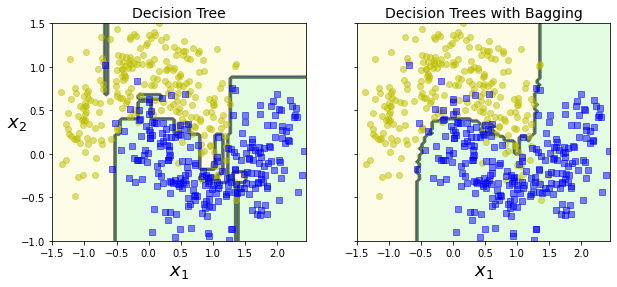

In [24]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)

plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")

plt.show()

### 2-2. OOB 평가
배깅을 사용했을 때 선택되지 않은 샘플들을 OOB라고 합니다.\
OOB는 훈련에 사용되지 않으므로 별도 검증 샘플 없이 OOB를 사용하여 모델의 성능을 평가할 수 있습니다.

In [25]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=33
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [26]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.872

In [27]:
bag_clf.oob_decision_function_

array([[0.66111111, 0.33888889],
       [1.        , 0.        ],
       [0.99431818, 0.00568182],
       [0.95833333, 0.04166667],
       [0.99468085, 0.00531915],
       [1.        , 0.        ],
       [0.99456522, 0.00543478],
       [0.7150838 , 0.2849162 ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.00591716, 0.99408284],
       [0.99484536, 0.00515464],
       [0.        , 1.        ],
       [0.06842105, 0.93157895],
       [1.        , 0.        ],
       [0.98255814, 0.01744186],
       [0.21505376, 0.78494624],
       [0.20100503, 0.79899497],
       [1.        , 0.        ],
       [0.55952381, 0.44047619],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.47802198, 0.52197802],
       [0.5       , 0.5       ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.

## 4. 랜덤 포레스트

In [29]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=33)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [30]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=33
)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [31]:
np.sum(y_pred_rf == y_pred) / len(y_pred)

0.984

### 4-1. 엑스트라 트리
엑스트라 트리는 무작위한 트리를 만들기 위해 후보 특성을 사용해 무작위로 분할한 다음, 최상의 분할을 선택합니다.\ 
최적의 임계값을 찾는 과정이 없기 때문에 일반적인 랜덤 포레스트보다 훨씬 빠르게 훈련할 수 있습니다.

같은 데이터셋에 대해 훈련했을 때, 랜덤 포레스트는 훈련에 약 3초 소요된 반면,\
엑스트라 트리는 1초도 되지 않아 훈련이 완료되었습니다.

In [32]:
from sklearn.ensemble import ExtraTreesClassifier

ext_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, random_state=33)
ext_clf.fit(X_train, y_train)

y_pred_et = ext_clf.predict(X_test)

각 모델의 정확도는 어느 쪽이 높은지 알 수 없습니다.\
실험을 통해 확인하는 것이 가장 좋은 방법입니다.

In [33]:
print("Random Forest : ", accuracy_score(y_pred, y_pred_rf))
print("Extra Trees   : ", accuracy_score(y_pred, y_pred_et))

Random Forest :  0.984
Extra Trees   :  0.968


### 4-2. 특성 중요도
랜덤 포레스트는 각 특성이 얼마나 중요한지 알기 쉽습니다. (= 즉 이해하기 쉬운 모델입니다.)\
특성 중요도는 특성별로 다음 식과 같이 계산하여 더한 뒤, 정규화하여 구합니다. \
- (현재 노드의 샘플 비율 x 불순도) - (왼쪽 자식 노드의 샘플 비율 x 불순도) - (오른쪽 자식 노드의 샘플 비율 x 불순도) 

불순도를 많이 감소시키는 특성일수록 특성의 중요도가 높게 평가됩니다.

In [36]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=33)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09699410855511946
sepal width (cm) 0.022530044376154554
petal length (cm) 0.44643574812819614
petal width (cm) 0.43404009894052986


In [37]:
rnd_clf.feature_importances_

array([0.09699411, 0.02253004, 0.44643575, 0.4340401 ])

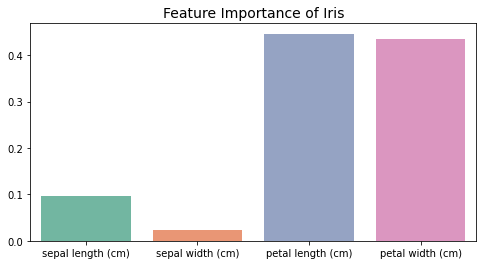

In [45]:
plt.figure(figsize=(8, 4))
sns.barplot(x=iris["feature_names"], y=rnd_clf.feature_importances_, palette="Set2")
plt.title("Feature Importance of Iris", fontsize=14)
plt.show()

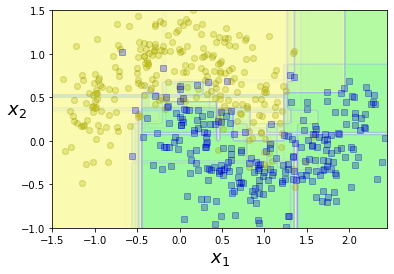

In [47]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state = 33 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axis=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)
plt.show()

다음은 mnist 데이터셋에 대해 Random Forest를 훈련시키고 특성 중요도를 확인하는 코드입니다.

In [48]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [50]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=33)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=33)

In [51]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap="hot", interpolation="nearest")
    plt.axis("off")

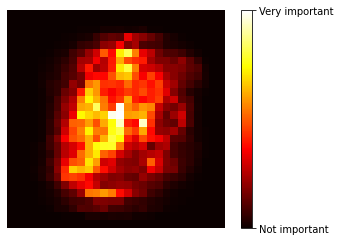

In [52]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

## 5. 부스팅

### 5-1. 에이다부스트 AdaBoost

In [53]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=33
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=33)

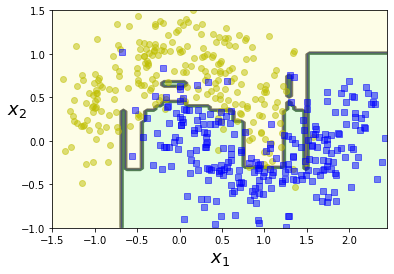

In [54]:
plot_decision_boundary(ada_clf, X, y)

<ipython-input-23-9f9a0f728ee4>:14: UserWarning: No contour levels were found within the data range.
  plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)


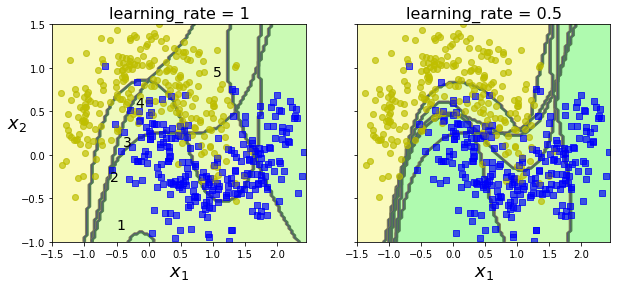

In [56]:
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=33)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum()
        alpha = learning_rate * np.log((1 - r) / r)
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # train for errors
        sample_weights /= sample_weights.sum()              # normalize
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.5, -0.85, "1", fontsize=14)
        plt.text(-0.6, -0.30, "2", fontsize=14)
        plt.text(-0.4,  0.10, "3", fontsize=14)
        plt.text(-0.2,  0.55, "4", fontsize=14)
        plt.text( 1.0,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

### 5.2 그래디언트 부스팅 Gradient Boosting
그래디언트 부스팅 역시 이전까지의 오차를 보정하도록 다음 예측기를 학습시키는 방법이지만,\
이전 예측기가 만든 잔여 오차를 사용하여 다음 예측기를 학습시킵니다.

다음은 순차적으로 예측기를 훈련시키는 코드입니다.

In [57]:
np.random.seed(33)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [66]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=33)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=33)

In [67]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=33)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=33)

In [68]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=33)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=33)

In [69]:
X_new = np.array([[0.8]])

In [70]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [71]:
y_pred

array([0.70741948])

사이킷런의 GradientBoostingRegressor와 같은 결과를 내는 것을 알 수 있습니다.

In [72]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=33)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=33)

In [73]:
gbrt.predict(X_new)

array([0.70741948])

다음 코드를 통해 순차적으로 3개의 트리를 훈련시키면서 변화하는 예측 결과를 확인할 수 있습니다.

In [77]:
def plot_predictions(regressors, X, y, axis, label=None, style='r-', data_style='b.', data_label=None):
    x1 = np.linspace(axis[0], axis[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axis)

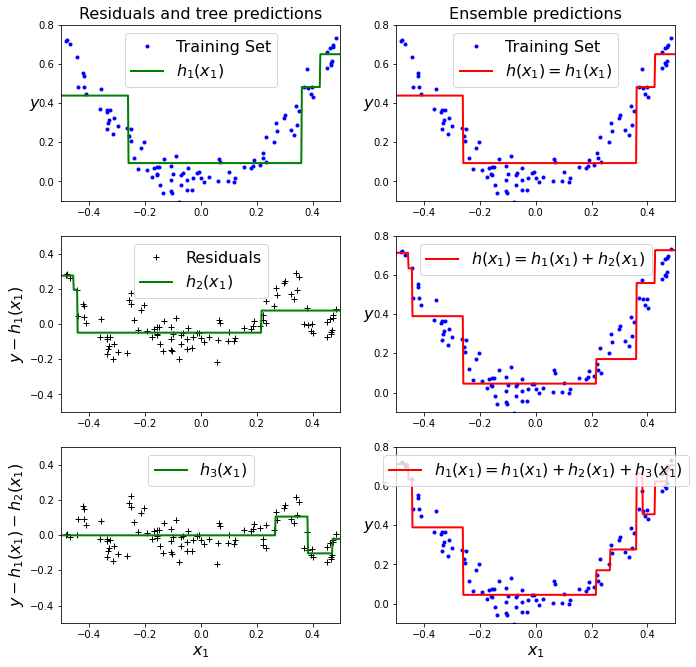

In [79]:
axis = [-0.5, 0.5, -0.1, 0.8]
axis2 = [-0.5, 0.5, -0.5, 0.5]
plt.figure(figsize=(11, 11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axis=axis, label="$h_1(x_1)$", style="g-", data_label="Training Set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axis=axis, label="$h(x_1) = h_1(x_1)$", data_label="Training Set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axis=axis2, label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axis=axis, label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axis=axis2, label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axis=axis, label="$h_1(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

다음 코드에서는 GradientBoostingRegressor를 훈련시킨 결과를 확인할 수 있습니다.\
n_estimators=3일 때(왼쪽), 위와 같이 3개의 트리를 훈련시킨 경우와 같은 결과를 보였습니다.\
트리의 수를 늘린 경우(오른쪽)에는 데이터의 분포에 더 가까워졌지만 과대적합된 것을 볼 수 있습니다.

In [74]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=33)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=33)

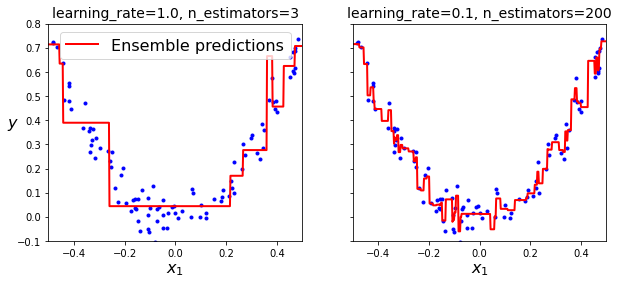

In [82]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axis=axis, label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axis=axis)
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

조기종료를 사용하여 과대적합이 발생하지 않는 최적의 트리 수를 찾을 수 있습니다.

In [86]:
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=33)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=33)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=33)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=38, random_state=33)

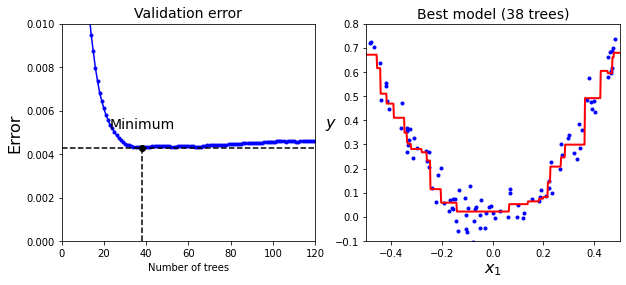

In [87]:
min_error = np.min(errors)

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axis=axis)
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

다음은 5 에포크 동안 향상되지 않을 때 조기종료를 하는 코드입니다.

In [88]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=33)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break

In [89]:
print(gbrt.n_estimators)

43


In [90]:
print("Minimum validation MSE: ", min_val_error)

Minimum validation MSE:  0.004303297480846267
